# Time-dependent Schrödinger Equation

Consider the time-dependent one-dimensional quantum harmonic oscillator defined by the Hamiltonian:

$$
H = \frac{\hat{p}^2}{2m} + \frac{\omega^2}{2m} \left(\hat{q} - q_0(t)\right)^2
$$

where:
$$
q_0(t) = \frac{t}{T}, \quad t \in [0, T].
$$

The initial state is given by:
$$
|\Psi_0\rangle = |n = 0\rangle
$$
(the ground state of the harmonic oscillator).

Note: we will use the standard convention of $\hbar = m = 1$ .

## Objectives

1. Compute the time-evolved state $(|\Psi(t)\rangle)$ for different values of $(T)$.
2. Plot:
   - The square norm of $(|\Psi(t)\rangle)$ as a function of $(q)$ at different times.
   - The average position of the particle $(\langle q(t) \rangle)$ as a function of time $(t)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy.polynomial.hermite import hermval
from numpy.linalg import norm
from scipy.special import factorial
from matplotlib import animation  # for creating gifs
import aux

## Solution ##

The analytical expression for the eigenfunctions for this Hamiltonian can be expressed through the Hermite polynomials as follows:

$$
Ψ_n(q; t) = \left(\frac{ω}{π}\right)^{1/4}\frac{1}{\sqrt{2^nn!}}
            \exp\left({\frac{-ω(q - q₀(t))^2}{2}}\right)
            H_n\left(\sqrt{ω} (q - q₀(t))\right)
$$

So, first, let's define those.

In [2]:
# Define Hermite polynomials
def hermite(x,n: int):
    
    # All coefficients of the Hermite polynomial set to zero except for the n-th, which is set to 1
    herm_coeff = np.zeros(n+1)
    herm_coeff[n] = 1
    
    # Compute the polynomial using the function from Scipy
    herm_pol = hermval(x,herm_coeff)
    
    return herm_pol

def decomposition(x, n, omega):
    ## Returns the eigenfunction of order n for the 1d quantum harmonic oscillator
    
    prefactor = (omega / np.pi)**(1/4) * (1 / np.sqrt(2**n * factorial(n)))
    psi = prefactor * np.exp(-omega * (x**2) / 2) * hermite(np.sqrt(omega) * x, n)
    '''
    # NORMALIZATION !!!!
    dx = x[1] - x[0] # grid
    psi_normalized = psi / np.sqrt(np.sum(np.abs(psi)**2) * dx)
    '''
    psi_normalized = psi / norm(psi)
    return psi_normalized

# Objects inizialitation # 

Now, let's create classes for containing our operators and variables.

In [3]:
class Param:
    ## Class for containing the parameters used in the simulation
    
    def __init__(self,
                 xmax: float,
                 Nx: int,
                 tsim: float,
                 Nt: int,
                 omega: float,
                 im_time: bool = False) -> None:
    
        self.xmax = xmax
        self.Nx = Nx
        self.tsim = tsim
        self.Nt = Nt
        self.omega = omega
        self.im_time = im_time
        
        # Derived parameters
        self.dx = 2 * xmax/ Nx
        self.dt = tsim / Nt
        self.x = np.arange(-xmax, + xmax, self.dx)
        # Momentum, defined as 1/x and a prefactor from Fourier Transfrom
        self.dk = np.pi / xmax
        # Momentum grid
        self.k = np.concatenate((np.arange(0, Nx / 2), np.arange(-Nx / 2, 0))) * self.dk
        
class Operators:   
    # This class will hold the operators values
    
    def __init__(self, 
                 res: int,
                 par: Param,
                 voffset: float = 0.,
                 wfcoffset: float = 0.,
                 q0 = lambda q: 0,
                 n: int = 0) -> None:

        # Initialize the containers for the various operators
        self.V = np.empty(res, dtype=complex)
        self.R = np.empty(res, dtype=complex)
        self.K = np.empty(res, dtype=complex)
        self.wfc = np.empty(res, dtype=complex)
        
        
        # Time-dependent offset (default to zero)
        self.q0 = q0 or (lambda q: 0)
        
        # Initialize parameters and compute the energy
        if par is not None:
            self.init_operators(par, voffset, wfcoffset, n)
            self.compute_energy(par,)
            
    def init_operators(self, par: Param, voffset: float = 0, wfcoffset: float = 0, n: int = 0) -> None:
        
        # Initialize time-dependent offset
        q0 = self.q0(0)
        
        # Potential
        self.V = 0.5 * (par.omega ** 2) * (par.x - voffset - q0) **2
        self.wfc = decomposition(par.x - wfcoffset, n, par.omega).astype(complex)
        
        # Set the coefficient that regulates whether we're doing real or imaginary time evolution
        coeff = 1 if par.im_time else 1j    # for clarification, look at what done in the hands-on (ite_new.ipynb)
        
        ## Kinetic 
        ## We use Hausdorff approx (e^{A+B} \sim e^{A}*e^{B}+O(DeltaT^2))
        # In momentum space (kinetic part of the Hamiltonian)
        self.K = np.exp(-0.5 * (par.k **2) * par.dt * coeff)     # this is already the exponential term
        # In real space (potential part of the Hamiltonian)
        self.R = np.exp(-0.5 * self.V * par.dt * coeff)     # here U = e^{-V*t/2}e^{-K*t}e^{-v*t/2}+O{Deltat^3}   
        
    def compute_energy(self, par: Param) -> float:
    
        # Initialize the 3 wavefunctions: real space, momentum space, conjugate.
        wfc_r = self.wfc
        wfc_k = np.fft.fft(self.wfc)
        wfc_c = np.conj(self.wfc)
        
        # Compute both the real and momentum space energy terms
        E_r = wfc_c * self.R * wfc_r
        E_k = 0.5 * wfc_c * np.fft.ifft((par.k**2) * wfc_k) 
        
        # Sum over all space
        energy = (sum(E_r, E_k).real) * par.dx  # we take the real part since the energy is a real quantity by definition
        
        return energy
        

## Time evolution ##

Here we evolve our wavefunction in time, having the evolution operator (thanks Trotter-Suzuki approximation) as:
$$
\hat{U}(\Delta t) = e^{-i\hat{H}(t)\Delta t / \hbar} \\
                = e^{-i\hat{K}(t)\Delta t / \hbar} e^{-i\hat{V}(t)\Delta t / \hbar} + O(\Delta t^2) \\
                = e^{-i\hat{V}(t)\Delta t / 2\hbar} e^{-i\hat{K}(t)\Delta t / \hbar} e^{-i\hat{V}(t)\Delta t / 2\hbar} + O(\Delta t^3)
$$
The time evolution of the wavefunction for a time $t=N_t\Delta t$ is given by applying $N_t$ times the evolution operator, which equivaltes to:
$$
\Psi(x,t) = \hat{U}(\Delta t)^{N_t} \Psi(x,0)
$$
Then we move to the Fourier transform space and rewrite the evolution operator there.

In [4]:
def time_evolution(par: Param, opr: Operators, mode='plot') -> np.array: 
    
    # Available modes: 'plot', 'gif'
    if mode != 'plot' and  mode != 'gif':
        print('Mode not supported. Available modes are: \'plot\', \'gif\'')
        exit(1)
    print('Mode:', mode)
    
    if mode == 'gif':
        # Store the density value of the wavefunction for each timestep (1st half for real, 2nd half for momentum)
        densities = np.zeros((100,2*par.Nx)) 
        potential = np.zeros((100,par.Nx))
        avg_pos = np.zeros((100,par.Nx))
    
    else: 
        # Store the density value of the wavefunction for each timestep (1st half for real, 2nd half for momentum)
        densities = np.zeros((par.Nt,2*par.Nx)) 
        potential = np.zeros((par.Nt,par.Nx))
        avg_pos = np.zeros((par.Nt,par.Nx))
    
    # Index for the gif
    ii = 0
    
    for t in range(par.Nt):
        # Apply the evolution operator Nt time = U^{Nt}
        
        # Check normalization of the wavefunction (only for the real time case)
        if not par.im_time:
            aux.check_normalization_wfc(opr.wfc)
        
        # Update the time-dependent potential
        q0 = opr.q0(t * par.dt)
        opr.V = 0.5 * (par.omega ** 2) * (par.x - q0) **2
        
        
        # Update the real operator
        coeff = 1 if par.im_time else 1j
        opr.R = np.exp(-0.5 * opr.V * par.dt * coeff)
        
        # Apply the 'first half' of the potential part (real space)
        opr.wfc *= opr.R
        
        # Check normalization of the wavefunction (only for the real time case)
        if not par.im_time:
            aux.check_normalization_wfc(opr.wfc)
        
        # Move to momentum space
        opr.wfc = np.fft.fft(opr.wfc)
        
        # Check normalization of the wavefunction (only for the real time case)
        if not par.im_time:
            aux.check_normalization_wfc(opr.wfc, momentum_space=True, dk=par.dk)
        
        # Kinetic part
        opr.wfc *= opr.K
        
        # Check normalization of the wavefunction (only for the real time case)
        if not par.im_time:
            aux.check_normalization_wfc(opr.wfc, momentum_space=True, dk=par.dk)
        
        # Back to real space
        opr.wfc = np.fft.ifft(opr.wfc)
        
        # Check normalization of the wavefunction (only for the real time case)
        if not par.im_time:
            aux.check_normalization_wfc(opr.wfc)
        
        # 'Second half' of the potential part
        opr.wfc *= opr.R
        
        # Check normalization of the wavefunction (only for the real time case)
        if not par.im_time:
            aux.check_normalization_wfc(opr.wfc)
        
        # Density |Psi|^2
        density =  np.abs(opr.wfc)**2
        
        # Renormalization for imaginary time (here the evolution operator is not unitary anymore)
        if par.im_time:
            norm = np.sum(density * par.dx)
            opr.wfc /= np.sqrt(norm)
            density = np.abs(opr.wfc)**2
        
        if mode == 'gif':   
            # Save 100 snapshots
            if t % (par.Nt // 100) == 0 and ii < 100:
                # Save wfc 
                densities[ii, 0:par.Nx] = np.real(density)   # real space
                densities[ii, par.Nx:2 * par.Nx] = np.abs(np.fft.fft(opr.wfc)) ** 2   #momentum space
                
                # Save the potential
                potential[ii, :] = opr.V
                
                # Save the average position
                avg_pos[ii] = np.sum(par.x * density) * par.dx
                
        else:
            densities[t, 0:par.Nx] = np.real(density)   # real space
            densities[t, par.Nx:2 * par.Nx] = np.abs(np.fft.fft(opr.wfc)) ** 2   #momentum space
            
            # Save the potential
            potential[t, :] = opr.V
            
            # Save the average position
            avg_pos[t] = np.sum(par.x * density) * par.dx
            

        # Update the gif index
        ii += 1  
        
    return densities, potential, avg_pos
        

## Testing ##

The final energy of the systems is: 0.019995314635129578
1.0
Space: Real
Mode: plot
Checkpoint
Variable not normalized. Norm=22.360679774997894


ValueError: Execution stopped at checkpoint: Variable not normalized. Norm=22.360679774997894

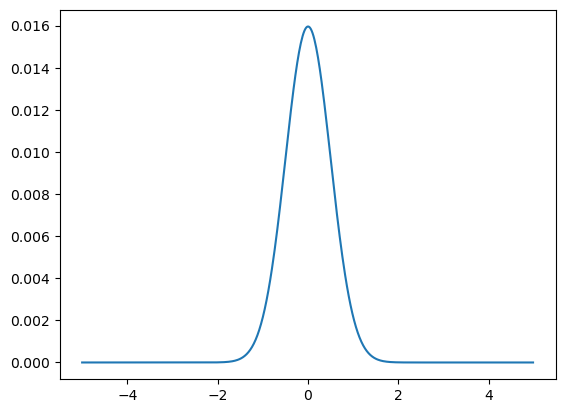

In [5]:
# SIMULATION PARAMETERS

xmax = 5.0
Nx = 500
tsim = 50
Nt = 1000
im_time = False
omega = 2.0


# Initialize the Param object
par = Param(xmax, Nx, tsim, Nt, omega, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = Nx
voffset = 0.0
wfcoffset = 0.0
n = 0
q0_func = lambda t: t / tsim 

# Initialize the Operators object
opr = Operators(res, par, voffset, wfcoffset, q0_func, n)
print(f"The final energy of the systems is: {opr.compute_energy(par)[-1]}")

print(norm(opr.wfc))
plt.plot(par.x,np.abs(opr.wfc)**2)
aux.check_normalization_wfc(opr.wfc)

# Run the simulation and get the results
space_str = 'Imaginary' if par.im_time else 'Real'
print('Space:', space_str)
density, potential, avg_position = time_evolution(par, opr, mode='plot')
print(density.shape)
print(avg_position.shape)
print(potential.shape)

In [ ]:
# plot density
plt.figure(figsize=(10, 5))
plt.imshow(density, aspect='auto', extent=[-xmax, xmax, 0, tsim], cmap='hot')
plt.colorbar(label='Density')
plt.title('Density evolution')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

# plot potential
plt.figure(figsize=(10, 5))
plt.imshow(potential, aspect='auto', extent=[-xmax, xmax, 0, tsim], cmap='hot')
plt.colorbar(label='Potential')
plt.title('Potential evolution')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

# plot average position
plt.figure(figsize=(10, 5))
plt.plot(avg_position)
plt.title(f'Average position evolution in {space_str} space(ω={par.omega})')
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.show()

# plot energy
plt.figure(figsize=(10, 5))
plt.plot(opr.compute_energy(par))
plt.title('Energy evolution')
plt.xlabel('t')
plt.ylabel('Energy')
plt.grid()
plt.show()

In [ ]:
# Define if we are in real or imaginary space
#par.im_time = False
#space_str = 'Imaginary' if par.im_time else 'Real'
print('Space:', space_str)

# Generate the data
density, potential, avg_position = time_evolution(par, opr)


# Set up the figure and axis for the animation
step_interval = max(par.Nt // 500, 1)  # Ensure at least 200 frames, adjust as needed
selected_frames = range(0, par.Nt, step_interval)

fig, ax = plt.subplots()
ax.set_xlim(-par.xmax, par.xmax)
ax.set_ylim(0, 1)
ax.set_xlabel("Position (x)")
ax.set_ylabel("Probability Density |ψ(x)|^2")
ax.set_title(f'{space_str} Space evolution (ω={par.omega})')

# Plot the potential and prepare the line for the wave function
line_density, = ax.plot([], [], lw=2, label="Wave Function |ψ(x)|^2", color='blue')
line_pot, = ax.plot([], [], label="Potential V(x)", color='gray', linestyle='--')
line_avg, = ax.plot([], [], label="Average position", color='red', linestyle='--')
ax.legend()
ax.grid()

# Initialization function for the animation
def init_line():
    line_density.set_data([], [])
    line_pot.set_data([], [])
    line_avg.set_data([], [])
    
    return line_density, line_pot, line_avg

# Animation function that updates the plot at each frame
def animate(i):
    x = par.x
    y_density = density[i, :par.Nx]
    y_pot = potential[i, :]
    x_avg = avg_position[i,0]
    
    line_density.set_data(x, y_density)
    line_pot.set_data(x, y_pot)
    line_avg.set_data(x_avg, [0, 1.5])
    
    return line_density, line_pot, line_avg

# Create the animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init_line, frames=selected_frames, interval=40, blit=True
)

# Save the animation as a GIF
writer = animation.PillowWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
anim.save(f'{space_str}_space.gif', writer=writer)

plt.show()